In [230]:
import yt.wrapper as yt
import yt.clickhouse as chyt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict, Counter
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from  scipy.stats import pearsonr, spearmanr, kendalltau, bernoulli
from tqdm.notebook import tqdm
import plotly.express as px
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve

sns.set()
%matplotlib inline

## Достаем данные

Инпут таблицы строятся такой ыклей: https://yql.yandex-team.ru/Operations/YuKYBq5OD9vWsrGCzzxfFVvt3hIm2j3VvzhAip94Tek=

Потом такой: https://yql.yandex-team.ru/Operations/YuKe7Lq3k100IW57GzmwMTuz_aXpRtEz7ml08JZwwcI=

In [111]:
def read_table(table_path):
    yt.config["proxy"]["url"] = "hahn.yt.yandex.net"
    client = yt.YtClient(proxy="hahn", config={"tabular_data_format": "dsv"})
    read_result = yt.read_table(table_path, raw=False)
    raw_data = [row for row in read_result.rows]
    df = pd.DataFrame(raw_data)
    return df

path = '//home/voice/polinakud/VA_2919_new_bayan_metric_for_ab/pandas_data'
df = read_table(path)

In [113]:
for i in range(len(df)):
    if df['features'][i] is None:
        df['features'][i] = {}
    df['features'][i]['time_play'] = df['time_play'][i]
    popularity_dict = df['popularity'][i]
    if not popularity_dict:
        popularity_dict = {}
    df['features'][i]['popularity_users'] = popularity_dict.get('users', 0)
    df['features'][i]['popularity_play'] =  popularity_dict.get('play', 0)

df = df[df.time_play < 1000].reset_index(drop=True)

/home/polinakud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [114]:
ALL_FEATURES_LIST = [
    'artist_like_180d',
     'artist_like_180d_alice',
     'artist_like_30d',
     'artist_like_30d_alice',
     'artist_play_180d',
     'artist_play_180d_alice',
     'artist_play_30d',
     'artist_play_30d_alice',
     'artist_radio_like_180d',
     'artist_radio_like_180d_alice',
     'artist_radio_like_30d',
     'artist_radio_like_30d_alice',
     'artist_radio_play_180d',
     'artist_radio_play_180d_alice',
     'artist_radio_play_30d',
     'artist_radio_play_30d_alice',
     'artist_radio_skip_180d',
     'artist_radio_skip_180d_alice',
     'artist_radio_skip_30d',
     'artist_radio_skip_30d_alice',
     'artist_skip_180d',
     'artist_skip_180d_alice',
     'artist_skip_30d',
     'artist_skip_30d_alice',
     'time_play',
     'popularity_users',
     'popularity_play',
     'track_like_180d',
     'track_like_180d_alice',
     'track_like_30d',
     'track_like_30d_alice',
     'track_play_180d',
     'track_play_180d_alice',
     'track_play_30d',
     'track_play_30d_alice',
     'track_radio_like_180d',
     'track_radio_like_180d_alice',
     'track_radio_like_30d',
     'track_radio_like_30d_alice',
     'track_radio_play_180d',
     'track_radio_play_180d_alice',
     'track_radio_play_30d',
     'track_radio_play_30d_alice',
     'track_radio_skip_180d',
     'track_radio_skip_180d_alice',
     'track_radio_skip_30d',
     'track_radio_skip_30d_alice',
     'track_skip_180d',
     'track_skip_180d_alice',
     'track_skip_30d',
     'track_skip_30d_alice'
]

ALL_FEATURES = set(ALL_FEATURES_LIST)

NON_USEFUL_FEATURES = {
    'artist_like_180d',
    'artist_like_180d_alice',
    'artist_like_30d',
    'artist_like_30d_alice',
    'artist_radio_like_180d',
     'artist_radio_like_180d_alice',
     'artist_radio_like_30d',
     'artist_radio_like_30d_alice',
    'track_radio_like_180d',
     'track_radio_like_180d_alice',
     'track_radio_like_30d',
     'track_radio_like_30d_alice',
     'track_like_180d_alice',
     'track_like_30d',
     'track_like_30d_alice'
}

## Немношко смотрим на данные

Построим несколько графиков в разбиении баян-небаян, чтобы увидеть, сильно ли отличаются распределения по фичам и таргету

Сначала количество треков в сессии

In [115]:
track_lengths = df.groupby(by='postroll_req_id').agg(
    len_session=pd.NamedAgg(column="track_id", aggfunc="count"),
    is_bayan=pd.NamedAgg(column="is_bayan", aggfunc="first"),
    uuid=pd.NamedAgg(column="uuid", aggfunc="first"),
).reset_index(drop=True)

track_listen_time = df.groupby(by='postroll_req_id').agg(
    avg_track_play=pd.NamedAgg(column="time_play", aggfunc="mean"),
    is_bayan=pd.NamedAgg(column="is_bayan", aggfunc="first"),
    uuid=pd.NamedAgg(column="uuid", aggfunc="first"),
).reset_index(drop=True)

Total sessions = 5675, avg session length = 11.321762114537444, median session length = 6.0
	For bayan: avg session length = 9.175366568914956, median session length = 5.0
	For not bayan: avg session length = 9.683404940923738, median session length = 6.0


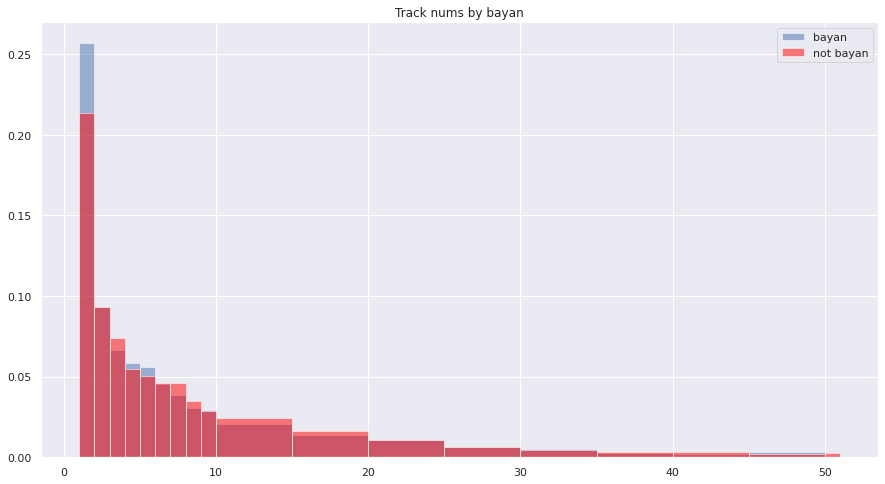

In [116]:
thr = 50
bins = np.concatenate([np.arange(1, 10, 1), np.arange(10, thr+1, 5), [51]])
track_lengths[track_lengths.len_session > thr] = 51
print(f'Total sessions = {len(track_lengths)}, avg session length = {np.mean(track_lengths.len_session)}, median session length = {np.median(track_lengths.len_session)}')
print(f'\tFor bayan: avg session length = {np.mean(track_lengths[track_lengths.is_bayan == 1].len_session)}, median session length = {np.median(track_lengths[track_lengths.is_bayan == 1].len_session)}')
print(f'\tFor not bayan: avg session length = {np.mean(track_lengths[track_lengths.is_bayan == 0].len_session)}, median session length = {np.median(track_lengths[track_lengths.is_bayan == 0].len_session)}')

plt.figure(figsize=(15,8))
plt.hist(track_lengths.len_session[track_lengths.is_bayan == 1], bins=bins, alpha=0.5, label='bayan', density=True)
plt.hist(track_lengths.len_session[track_lengths.is_bayan == 0], bins=bins, alpha=0.5, color='red', label='not bayan', density=True)
plt.title('Track nums by bayan')
plt.legend()
plt.show()

In [117]:
pvalue_for_track_num = mannwhitneyu(track_lengths[track_lengths.is_bayan == 1].len_session, track_lengths[track_lengths.is_bayan == 0].len_session).pvalue
pvalue_for_track_num_not_one_track = mannwhitneyu(track_lengths[np.logical_and(track_lengths.is_bayan == 1, track_lengths.len_session > 1)].len_session, track_lengths[np.logical_and(track_lengths.is_bayan == 0, track_lengths.len_session > 1)].len_session).pvalue
print(f'Pvalue for hypo, that track num in session is same distribution: {pvalue_for_track_num}')
print(f'Pvalue for hypo, that track num in session is same distribution, but only 2+ length sessions: {pvalue_for_track_num_not_one_track}')

Pvalue for hypo, that track num in session is same distribution: 0.0010237819091635483
Pvalue for hypo, that track num in session is same distribution, but only 2+ length sessions: 0.23203995016930784


Среди баянистых сессий больше сессий длиной 1 трек, немного больше экстремально длинный сессий (45-50). Среди сессий на отрезке 6-15 больше небаянистых, чем баянистых.

Статзначимая разница длин сессий между баянами и небаянами только с учетом сессий из 1 трека

Теперь смотрим на среднюю длину прослушивания трека в сессии

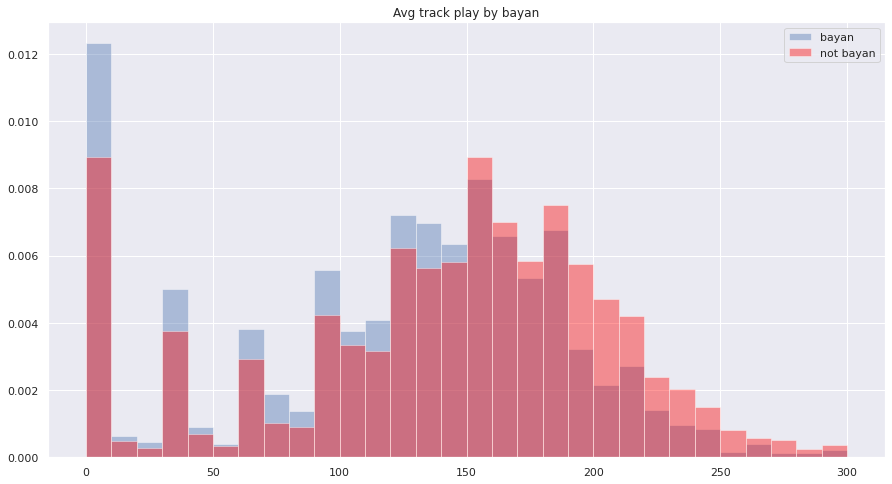

In [118]:
plt.figure(figsize=(15,8))
plt.hist(track_listen_time.avg_track_play[track_listen_time.is_bayan == 1], range=(0, 300), bins=30, alpha=0.4, label='bayan', density=True)
plt.hist(track_listen_time.avg_track_play[track_listen_time.is_bayan == 0], range=(0, 300), bins=30, alpha=0.4, color='red', label='not bayan', density=True)
plt.title('Avg track play by bayan')
plt.legend()
plt.show()

In [119]:
pvalue_for_avg_track_play = mannwhitneyu(track_listen_time[track_listen_time.is_bayan == 1].avg_track_play, track_listen_time[track_listen_time.is_bayan == 0].avg_track_play).pvalue
pvalue_for_avg_track_play_not_one_track = mannwhitneyu(track_listen_time[np.logical_and(track_listen_time.is_bayan == 1, track_listen_time.avg_track_play > 0)].avg_track_play, track_listen_time[np.logical_and(track_listen_time.is_bayan == 0, track_listen_time.avg_track_play > 0)].avg_track_play).pvalue
print(f'Pvalue for hypo, that avg listen time in session is same distribution: {pvalue_for_avg_track_play}')
print(f'Pvalue for hypo, that avg listen time in session is same distribution, but only 0+ avg time: {pvalue_for_avg_track_play_not_one_track}')

Pvalue for hypo, that avg listen time in session is same distribution: 1.2797375442727986e-24
Pvalue for hypo, that avg listen time in session is same distribution, but only 0+ avg time: 2.841900951426757e-24


Для небаянистых сессий средняя длина прослушивания больше, чем для баянистых. В баянистых сессиях также больше сессий, где все треки были скипнуты (вероятно это засчет сессий из одного трека)

И последнее - построим распределения по фичам, для баянистых и небаянистых сессий. Берем фичи всех треков, считаем баяном, если из баянистой сессии, небаяном иначе.

In [177]:
def plot_feature_data(df, feature, plot_type='hist', bins=20):
    thr = np.quantile([item.get(feature, 0) for item in df.features], 0.95)
    if thr == 0:
        thr = np.max([item.get(feature, 0) for item in df.features])/2
    if 'artist' in feature:
        thr = min(thr, 10)
    elif 'track' in feature:
        thr = min(thr, 5)
    elif 'popularity' in feature:
        thr = np.quantile([item.get(feature, 0) for item in df.features], 0.7)
    non_bayan_data = [item.get(feature, 0) for item in df[df.is_bayan == 0].features]
    bayan_data = [item.get(feature, 0) for item in df[df.is_bayan == 1].features]
    if plot_type == 'hist':
        plt.hist(bayan_data, range=(0, thr), bins=bins, alpha=0.5, label='bayan', density=True)
        plt.hist(non_bayan_data, range=(0, thr), bins=bins, alpha=0.5, label='not bayan', density=True, color='red')
    elif plot_type == 'kde':
        pd.Series(non_bayan_data).plot.kde(label='not_bayan')
        pd.Series(bayan_data).plot.kde(label='bayan')
    plt.title(f'{feature}')
    plt.xlim(0, thr)
    plt.legend()

  0%|          | 0/36 [00:00<?, ?it/s]

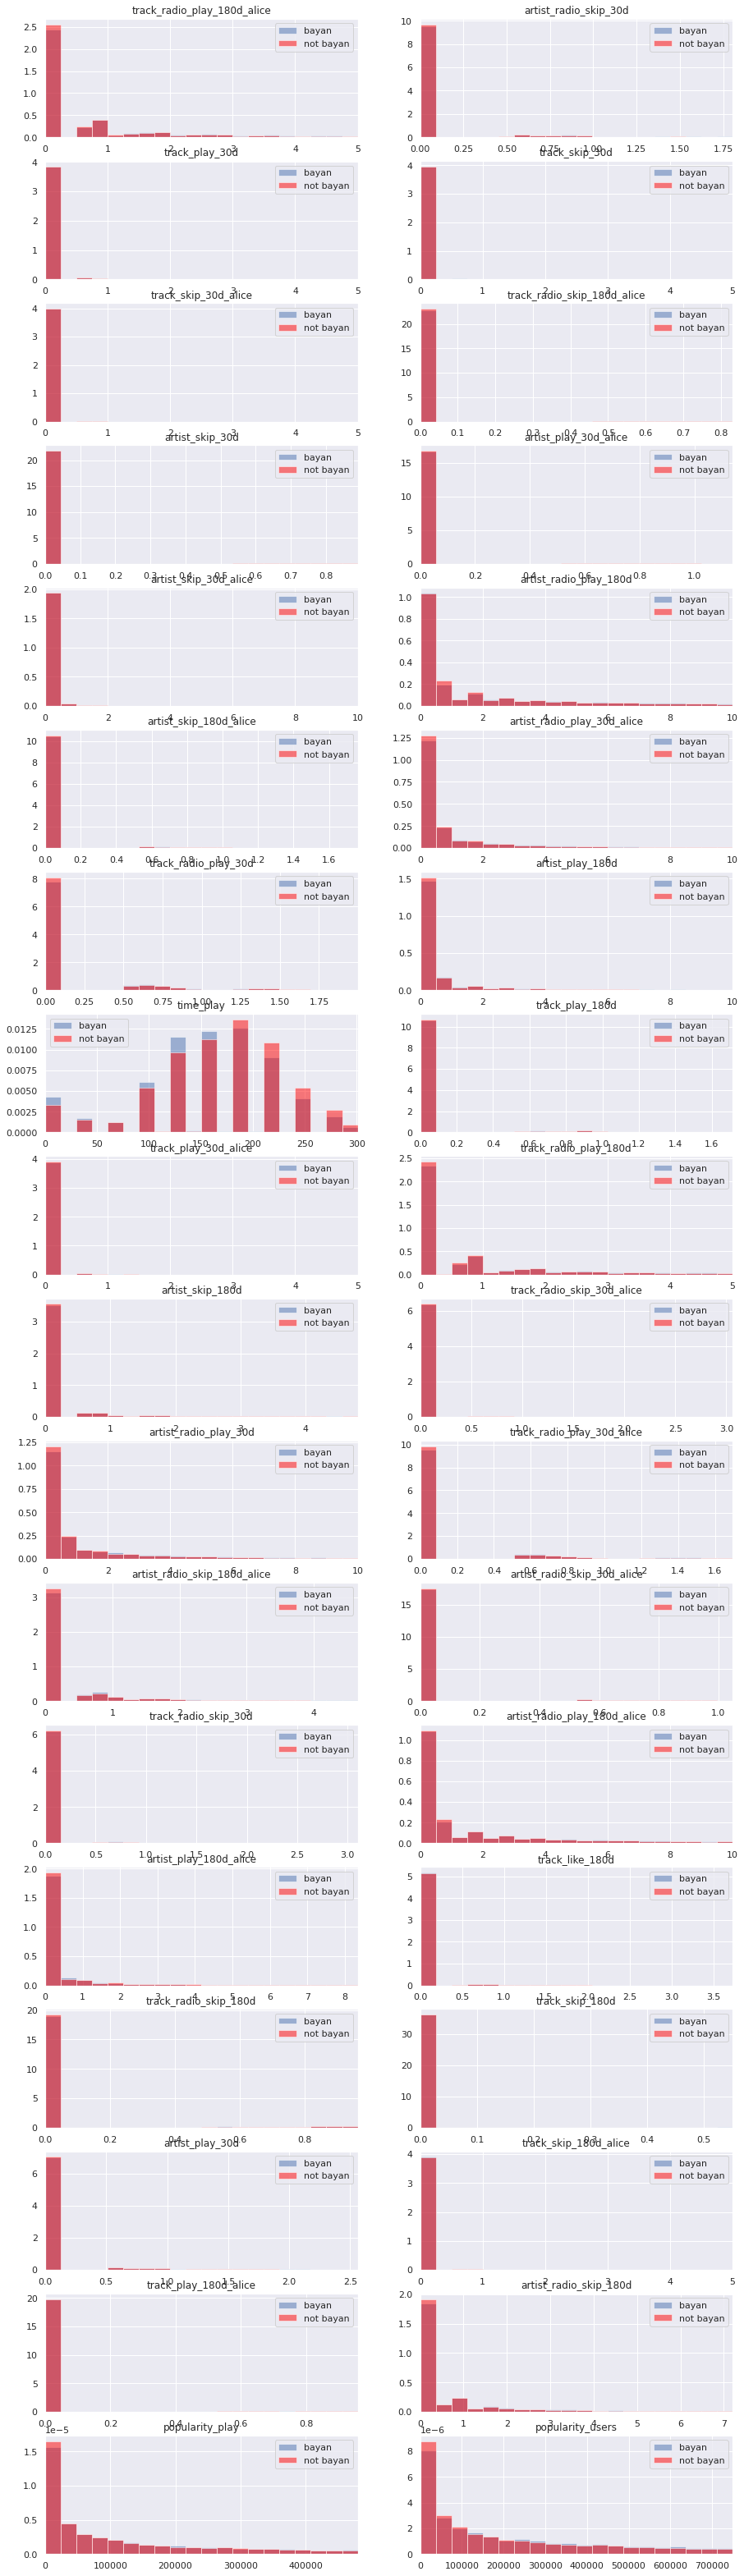

In [135]:
i = 1
plt.figure(figsize=(15, 60))
for feature in tqdm(ALL_FEATURES - NON_USEFUL_FEATURES):
    plt.subplot(len(ALL_FEATURES - NON_USEFUL_FEATURES)//2 + 1, 2, i)
    plot_feature_data(df, feature)
    i += 1
plt.show()

  0%|          | 0/36 [00:00<?, ?it/s]

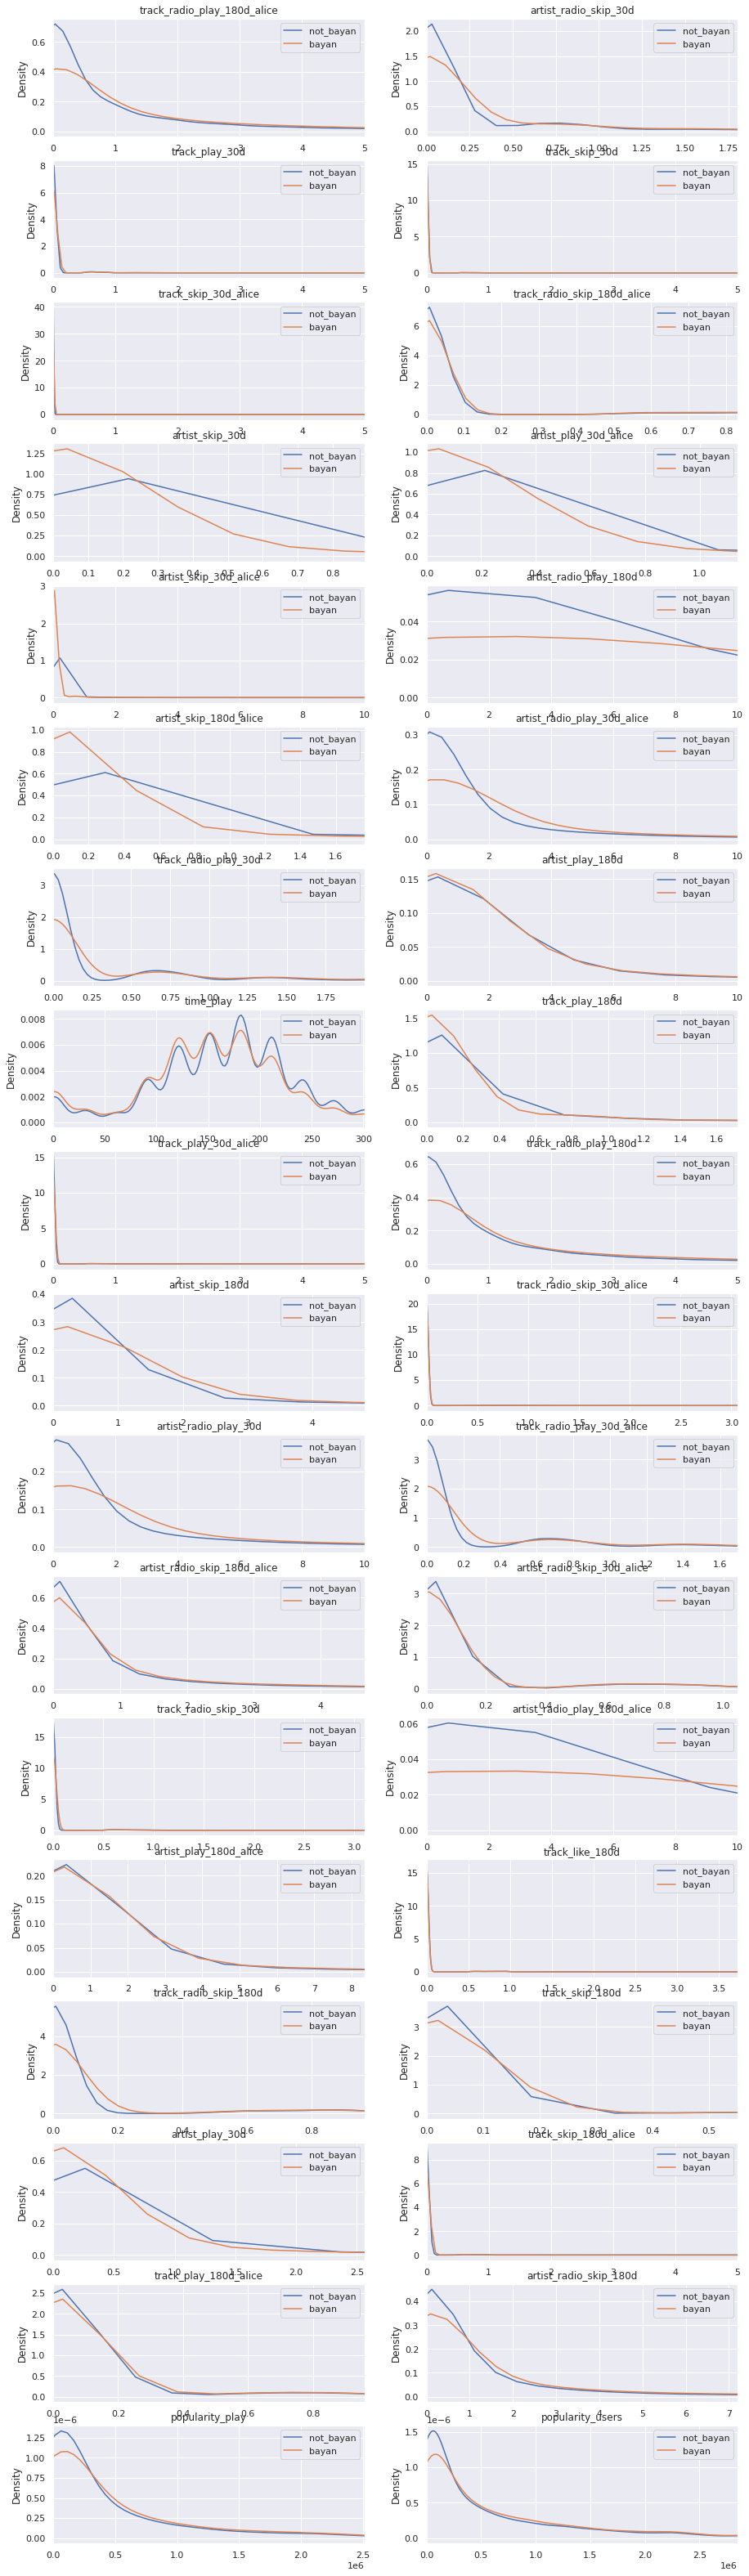

In [132]:
i = 1
plt.figure(figsize=(15, 60))
for feature in tqdm(ALL_FEATURES - NON_USEFUL_FEATURES):
    plt.subplot(len(ALL_FEATURES - NON_USEFUL_FEATURES)//2 + 1, 2, i)

    plot_feature_data(df, feature, 'kde')
    i += 1
    
plt.show()

**Вывод**: На графиках некоторых фичей видно, что распределения в целом немного различные - распределения для баянов немного больше смещены вправо. Однако разница труднозаметная

По популярности треков тоже видно, что среди непопулярных небаянов больше, чем баянов

## И еще немношко посмотрим на данные, теперь с группировкой

In [179]:
def get_req_id_features(features_list, agg_function=lambda x: np.quantile(x, 0.5), function_name='agg_func'):
    features_req_id = defaultdict(list)
    new_tracks_num = 0
    for item in features_list:
        #if item['time_play'] > 60:
        item_is_new_track = all([item.get(feature, 0) == 0 for feature in ALL_FEATURES if 'track' in feature or 'artist' in feature])
        if item_is_new_track:
            new_tracks_num += 1
            for feature in ['popularity_play', 'popularity_users']:
                features_req_id[feature].append(item.get(feature, 0))
        else:
            for feature in ALL_FEATURES - NON_USEFUL_FEATURES:
                features_req_id[feature].append(item.get(feature, 0))
    
    features_aggregated = {feature + f'_{function_name}': agg_function(features_req_id[feature]) for feature in features_req_id}
    features_aggregated['new_share'] = float(new_tracks_num)/len(features_list)
    features_aggregated['track_num'] = len(features_list)
    return features_aggregated

In [180]:
grouped_df = df.groupby(by='postroll_req_id').agg(
        is_bayan=pd.NamedAgg(column="is_bayan", aggfunc="first"),
        uuid=pd.NamedAgg(column="uuid", aggfunc="first"),
        features_agg=pd.NamedAgg(column="features", aggfunc=lambda x: get_req_id_features(x, lambda y: np.quantile(y, 0.5)))
    ).reset_index(drop=True)

grouped_df = grouped_df[grouped_df.features_agg != {}].reset_index(drop=True)
for feature in grouped_df.features_agg[0]:
    grouped_df[feature] = [item.get(feature, 0) for item in grouped_df.features_agg]
grouped_df = grouped_df.drop(columns=['features_agg'])

Посмотрим на распределение доли совсем новых (по нашим счетчикам) треков в пользовательских сессиях

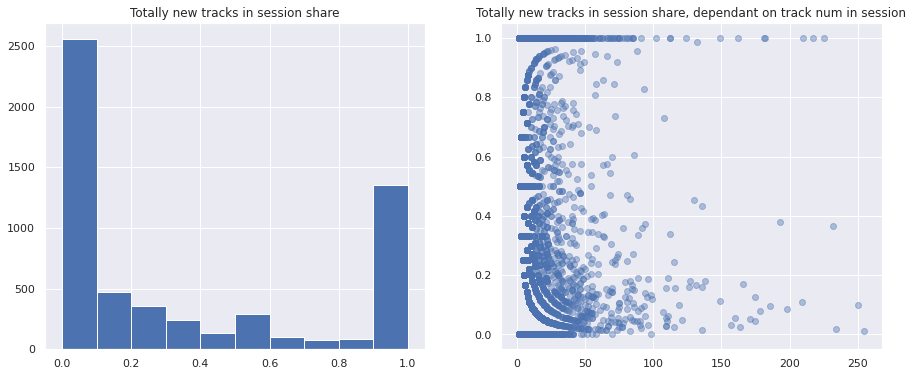

In [181]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.hist(grouped_df.new_share)
plt.title('Totally new tracks in session share')
plt.subplot(1,2,2)
plt.scatter(grouped_df.track_num, grouped_df.new_share, alpha=0.4)
plt.title('Totally new tracks in session share, dependant on track num in session')
plt.show()
plt.show()

Есть довольно много сессий вообще без нового, и много сессий только с новым. Это верно для разных количеств треков в сессии, не только для сессий из одного трека)

Посмотрим, сколько людей отвечают "баян" для экстремальных значений доли нового

In [189]:
is_bayan_only_new = np.sum(grouped_df[grouped_df.new_share == 1].is_bayan)/len(grouped_df[grouped_df.new_share == 1])
is_bayan_only_heard = np.sum(grouped_df[grouped_df.new_share == 0].is_bayan)/len(grouped_df[grouped_df.new_share == 0])

print(f'Only new tracks in session: {is_bayan_only_new} of people say it is bayan')
print(f'Only heard tracks in session: {is_bayan_only_heard} of people say it is bayan')

Only new tracks in session: 0.3460949464012251 of people say it is bayan
Only heard tracks in session: 0.33428165007112376 of people say it is bayan


Доли отличаются не в ту сторону) Для сессий с только новыми для них треками люди даже чаще говорят, что это баян

Смотрю, можем ли мы по популярности отличить, баянит или не баянит в сессии

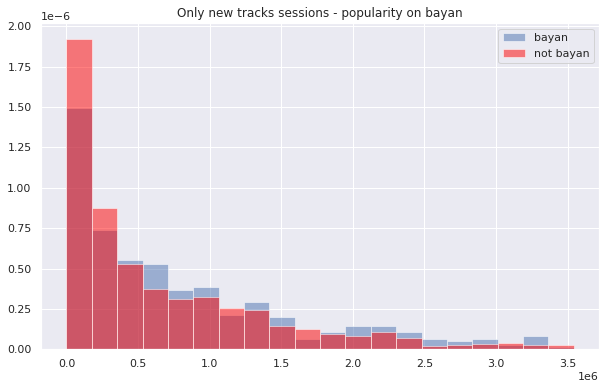

In [188]:
thr = np.quantile(grouped_df[grouped_df.new_share == 1].popularity_users_agg_func, 0.95)

non_bayan_data = grouped_df[np.logical_and(grouped_df.new_share == 1, grouped_df.is_bayan == 0)].popularity_users_agg_func
bayan_data = grouped_df[np.logical_and(grouped_df.new_share == 1, grouped_df.is_bayan == 1)].popularity_users_agg_func

plt.figure(figsize=(10,6))
plt.hist(bayan_data, range=(0, thr), bins=20, alpha=0.5, label='bayan', density=True)
plt.hist(non_bayan_data, range=(0, thr), bins=20, alpha=0.5, label='not bayan', density=True, color='red')
plt.title('Only new tracks sessions - popularity on bayan')
plt.legend()
plt.show()

Для баянистых и небаянистых сессий медианная популярность треков в потоке отличается, но не сказать, что разительно отличается.

## Предсказываем, что скажет пользователь - баян или нет

Что доп проверено

- Построить корреляции фичей с таргетом
- Графики по фичам в разрезе баян-небаян сделать красивее (мельче бины, больше отрезать пустого справа)
- Обучить на агрегации-среднем
- Отфильтровать первый трек из проигранных за сессию треков, если были включены рекомендации по треку
- AUC посмотреть для моделей, мб при другом пороге классификатора лучше качество предсказания?
- Глобальная популярность трека/популярность - добавила в фичи. Кажется, что популярные треки ощущаются баянами

Что не смотрела 
- Поджойнить фичи с фичами DJ, посмотреть, что похожие


Фичи агрегируются так: сначала берутся только новые треки из потока (ни одна из фичей не больше нуля). Такие треки не должны добавлять к ощущению баянистости, а если и будут, то отличить по фичам мы их не можем, так что эти фичи учитывать нет смысла. Кажется, что для таких треков важна только их доля в потоке. После этого для оставшихся треков по каждой фиче создается список значений, к этому списку применяется какая-то аггрегатная функция (медиана, максимум, среднее, квантиль выше медианы (75 например)). Так получаем список фичей для одной сессии

Единственные фичи, которые учитываются и для новых треков - популярность трека

### Как пытаемся предсказывать

Аггрегируем разными способами - среднее, медиана, квантили - как описано выше.
На фичах строим график с корреляциями фичей с таргетом. 

Еще делим на трейн-тест и обучаем несколько моделей - логрег, случайный лес, катбуст - предсказывать, будет ли сессия баяном

In [237]:
def test_grouping(df, agg_function=lambda x: np.quantile(x, 0.5), function_name='agg_func'):
    grouped_df = df.groupby(by='postroll_req_id').agg(
        is_bayan=pd.NamedAgg(column="is_bayan", aggfunc="first"),
        uuid=pd.NamedAgg(column="uuid", aggfunc="first"),
        features_agg=pd.NamedAgg(column="features", aggfunc=lambda x: get_req_id_features(x, agg_function, function_name))
    ).reset_index(drop=True)
    
    grouped_df = grouped_df[grouped_df.features_agg != {}].reset_index(drop=True)
    for feature in grouped_df.features_agg[0]:
        if '180' in feature or 'popularity' in feature:
            grouped_df[feature] = [item.get(feature, 0) for item in grouped_df.features_agg]
    grouped_df = grouped_df.drop(columns=['features_agg'])
    bayan_share = np.sum(grouped_df.is_bayan)/len(grouped_df.is_bayan)
    print(f'Num items = {len(grouped_df.is_bayan)}, share bayans = {bayan_share}')
    
    train_uuid, test_uuid = train_test_split(list(set(grouped_df.uuid)), test_size=0.2, random_state=42)
    
    
    X = grouped_df.drop(columns=['is_bayan', 'uuid'])
    y = grouped_df[['is_bayan']]
    X_train = X[[uuid in train_uuid for uuid in grouped_df.uuid]]
    X_test = X[[uuid in test_uuid for uuid in grouped_df.uuid]]
    y_train = y[[uuid in train_uuid for uuid in grouped_df.uuid]]
    y_test = y[[uuid in test_uuid for uuid in grouped_df.uuid]]

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    features_list = list(X)
    features_corr = {}
    for feature in features_list: 
        features_corr[feature] = {'pearson': pearsonr(np.array(X[feature], dtype='float').flatten(), np.array(y, dtype='float').flatten()),
                                 'spearman': spearmanr(np.array(X[feature], dtype='float').flatten(), np.array(y, dtype='float').flatten()),
                                 'kendalltau': kendalltau(np.array(X[feature], dtype='float').flatten(), np.array(y, dtype='float').flatten())}

    sorted_features = sorted(features_list, key=lambda x: features_corr[x]['pearson'][0], reverse=True)

    print(f'Max correlation for feature {sorted_features[0]}, corr = {features_corr[sorted_features[0]]["pearson"][0]}')
    plt.scatter(np.ones(len(sorted_features)), [features_corr[feature]['pearson'][0] for feature in sorted_features],
               c='blue', label='pearson')
    plt.scatter(np.ones(len(sorted_features)) + 1, [features_corr[feature]['spearman'][0] for feature in sorted_features],
               c='red', label='spearman')
    plt.scatter(np.ones(len(sorted_features)) + 2, [features_corr[feature]['kendalltau'][0] for feature in sorted_features],
               c='green', label='kendalltau')
    plt.title('Correlation plot')
    plt.legend()
    plt.show()
    
#     Interactive plot - for out-of-function use
#     px.scatter(pd.DataFrame({'x': x_data, 
#                  'y': y_data, 
#                  'names': sorted_features + sorted_features + sorted_features,
#                    'colors': ['blue' for feature in sorted_features] + ['red' for feature in sorted_features] + ['green' for feature in sorted_features]}),
#                    x='x', y='y', hover_name='names', color='colors', title='Correlation plot')
    
    
    
    most_corr_non_popularity_feature = [feature for feature in sorted_features if not 'popularity' in feature][0]
    thr_bayan_for_corr_feature = np.quantile(X_train[most_corr_non_popularity_feature], 1-bayan_share)
    
    print('Most corr feature results:')
    linspace_for_most_corr_scores = np.linspace(0, np.max(X_train[most_corr_non_popularity_feature]), 200)
    most_corr_scores = []
    for thr in linspace_for_most_corr_scores:
        most_corr_scores.append({'precision_score': precision_score(y_test, X_test[most_corr_non_popularity_feature] > thr),
                                 'recall_score': recall_score(y_test, X_test[most_corr_non_popularity_feature] > thr)})
    
    plt.figure(figsize=(10,6))
    plt.scatter([item['recall_score'] for item in most_corr_scores], [item['precision_score'] for item in most_corr_scores])
    plt.ylabel('precision')
    plt.xlabel('recall')
    plt.title('Precision-recall for most corr feature, diff thr')
    plt.show()
        
    print(f'\t accuracy: {accuracy_score(y_test, X_test[most_corr_non_popularity_feature] > thr_bayan_for_corr_feature)}, roc_auc_score: {roc_auc_score(y_test, X_test[most_corr_non_popularity_feature]/np.sum(X_test[most_corr_non_popularity_feature]))}')
    print(f'\t Num predicted bayans = {np.sum(X_test[most_corr_non_popularity_feature] > thr_bayan_for_corr_feature)}')
    
    print('Random results:')
    print(f'\t accuracy: {accuracy_score(y_test, np.random.random(len(y_test)) > float(np.sum(y_test)/len(y_test)))}')

    print('Constant results (everything is not bayan):')
    print(f'\t accuracy: {accuracy_score(y_test, np.zeros(len(y_test)))}')

    clf = LogisticRegression()
    clf.fit(X_train_scaled, y_train)
    print('Logistic regression results:')
    print(f'\t accuracy: {accuracy_score(y_test, clf.predict(X_test_scaled))}, roc_auc_score: {roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:, 1])}')
    print(f'\t Num predicted bayans = {np.sum(clf.predict(X_test_scaled))}')
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    print('Random forest results:')
    print(f'\t accuracy: {accuracy_score(y_test, clf.predict(X_test))}, roc_auc_score: {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])}')
    print(f'\t Num predicted bayans = {np.sum(clf.predict(X_test))}')

    clf = CatBoostClassifier(iterations=100,
                           depth=4,
                           learning_rate=0.1,
                           verbose=False)
    clf.fit(X_train, y_train)

    print('Catboost results:')
    print(f'\t accuracy: {accuracy_score(y_test, clf.predict(X_test))}, roc_auc_score: {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])}')
    print(f'\tNum predicted bayans = {np.sum(clf.predict(X_test))}')

    fpr, tpr, threshold = roc_curve(y_test,  clf.predict_proba(X_test)[:, 1])
    plt.title('ROC curve for catboost')
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Num items = 5675, share bayans = 0.3133039647577093
Max correlation for feature popularity_users_agg_func, corr = 0.06318635908506696


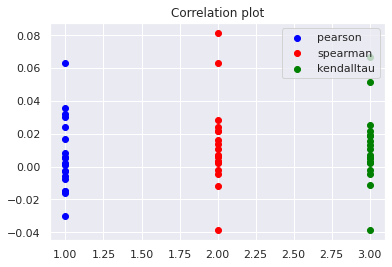

Most corr feature results:


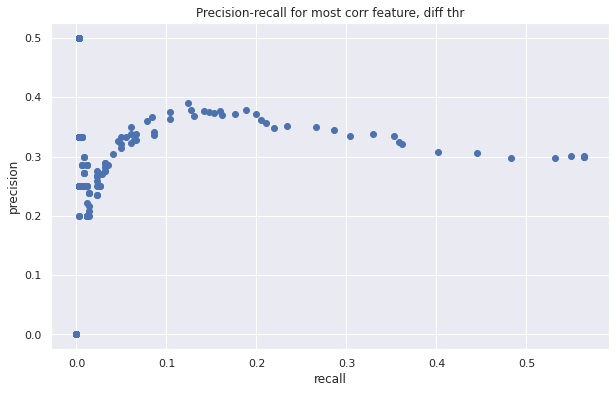

	 accuracy: 0.5769569041336852, roc_auc_score: 0.5095419568410514
	 Num predicted bayans = 385
Random results:
	 accuracy: 0.42656112576956906
Constant results (everything is not bayan):
	 accuracy: 0.6956904133685137
Logistic regression results:
	 accuracy: 0.6983289357959542, roc_auc_score: 0.5565684762830396
	 Num predicted bayans = 9
Random forest results:
	 accuracy: 0.6534740545294635, roc_auc_score: 0.5240458043158949
	 Num predicted bayans = 130
Catboost results:
	 accuracy: 0.6956904133685137, roc_auc_score: 0.5519116798082474
	Num predicted bayans = 0


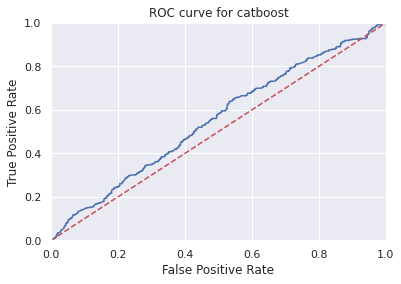

In [238]:
test_grouping(df)

Для аггрегации "75 квантиль" для всех фичей - логрегрессия и катбуст предсказывают очень мало баянов, roc-auc плохой, accuracy почти не отличается от константы.
Для случайного леса - accuracy хуже константы, roc-auc суперплохой.

Для предсказания по одной самой коррелирующей фиче - точность для всех порогов меньше 0.5.

Результат предсказания плохой, по таким моделям нельзя предсказать баянистость.

Num items = 5675, share bayans = 0.3133039647577093
Max correlation for feature popularity_users_agg_func, corr = 0.06299273632756454


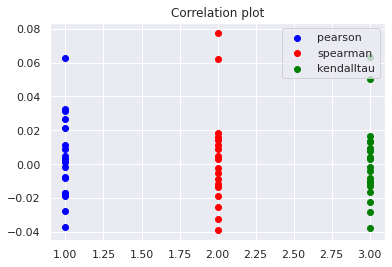

Most corr feature results:


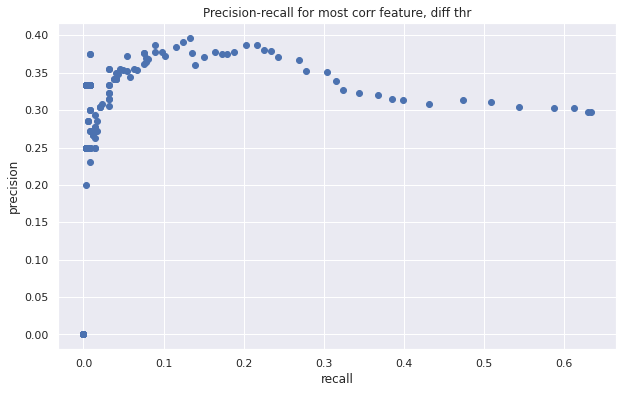

	 accuracy: 0.575197889182058, roc_auc_score: 0.5122476122271509
	 Num predicted bayans = 385
Random results:
	 accuracy: 0.4133685136323659
Constant results (everything is not bayan):
	 accuracy: 0.6956904133685137
Logistic regression results:
	 accuracy: 0.6992084432717678, roc_auc_score: 0.5524341763919236
	 Num predicted bayans = 4
Random forest results:
	 accuracy: 0.662269129287599, roc_auc_score: 0.529530191533363
	 Num predicted bayans = 128
Catboost results:
	 accuracy: 0.6948109058927001, roc_auc_score: 0.5608763327316706
	Num predicted bayans = 1


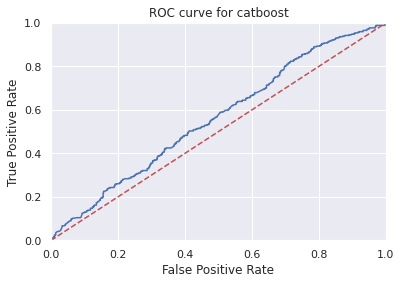

In [239]:
test_grouping(df, agg_function=lambda x: np.mean(x))

Для аггрегации средним для всех фичей - все то же самое

Num items = 5675, share bayans = 0.3133039647577093
Max correlation for feature popularity_users_agg_func, corr = 0.06318635908506696


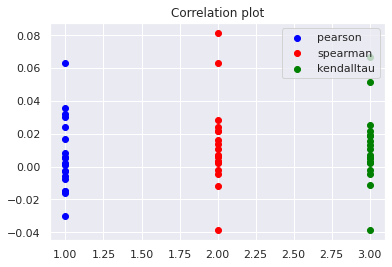

Most corr feature results:


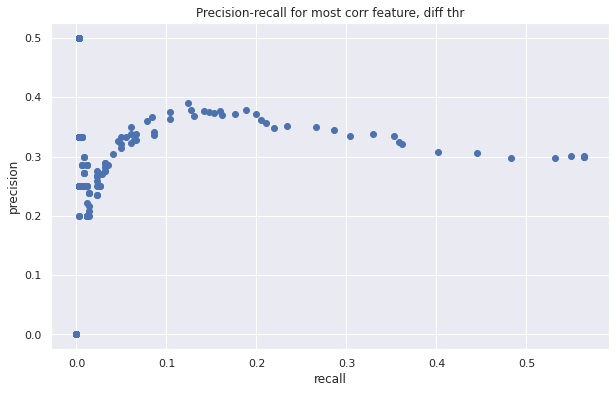

	 accuracy: 0.5769569041336852, roc_auc_score: 0.5095419568410514
	 Num predicted bayans = 385
Random results:
	 accuracy: 0.4080914687774846
Constant results (everything is not bayan):
	 accuracy: 0.6956904133685137
Logistic regression results:
	 accuracy: 0.6983289357959542, roc_auc_score: 0.5565684762830396
	 Num predicted bayans = 9
Random forest results:
	 accuracy: 0.6552330694810906, roc_auc_score: 0.5169592160358951
	 Num predicted bayans = 124
Catboost results:
	 accuracy: 0.6956904133685137, roc_auc_score: 0.5519116798082474
	Num predicted bayans = 0


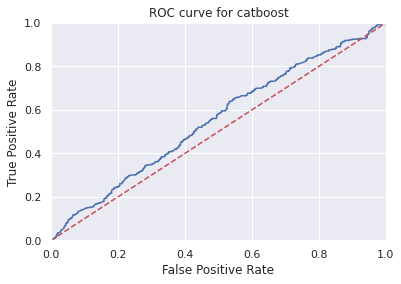

In [240]:
test_grouping(df, agg_function=lambda x: np.median(x))

Для агрегации медианой - все то же самое.

### Итого
- Распределения фичей треков в баянистых и небаянистых сессиях отличаются довольно мало
- Пользователи практически одинаково часто отвечают "да" на вопрос постролла и в случае, когда в сессии были только новые (по нашим фичам) треки, и в случае, когда в сессии были только знакомые треки.
- Лучше всего коррелирует с таргетом "баянистости" фича популярности трека в этот день (сколько юзеров прослушали данный трек в этот день). Однако даже эта фича имеет значение корреляции 0.06 - очень мало. Эта фича не помогает норм предсказывать, будет ли сессия баяном, плюс не является информативной с точки зрения метрики баянистости - плохо, что не привязана к опыту конкретного юзера
- Простые модели (пороги по одной фиче) и более сложные модели (логрег, случайный лес, катбуст) не позволяют предсказывать, будет ли сессия баянистой, вне зависимости от способы агрегации фичей по сессии. Качество моделей крайне низкое (сравнимо с константой), roc-auc скор также очень низкий.

По данным, на которые посмотрела в этом ноутбуке получается, что данные из постролльного опроса очень шумные, по фичам треков из сессии нельзя с хоть сколько-нибудь нормальной точностью понимать, ответит ли пользователь на постролл, что сессия была баянистая / не баянистая